# Extra Assignment — Stochastic Calculus  
### Simulation of OU Process, CIR Model, and Feynman–Kac PDE  
**Name:** Rishabh Kumar  
**Course:** Math 467 — Stochastic Calculus  
**Instructor:** Prof. Daniel Conus  
**Semester:** Fall 2025

This notebook contains full solutions, simulations, and explanations for Problems 1–3 in the Extra Assignment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Simulate Brownian Motion
def simulate_brownian(T, N):
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(N)
    W = np.concatenate(([0.0], np.cumsum(dW)))
    t = np.linspace(0, T, N + 1)
    return t, W

# Euler-Maruyama for OU
def simulate_OU_euler(a, sigma, x0, T, N, W):
    dt = T / N
    X = np.zeros(N + 1)
    X[0] = x0
    for n in range(N):
        dW = W[n+1] - W[n]
        X[n+1] = X[n] + (a - X[n]) * dt + sigma * dW
    return X

def monte_carlo_OU(a, sigma, x0, T, N, M):
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(M, N)
    X = np.zeros((M, N + 1))
    X[:,0] = x0
    for n in range(N):
        X[:,n+1] = X[:,n] + (a - X[:,n]) * dt + sigma * dW[:,n]
    return X[:,-1]

# Euler-Maruyama for CIR
def simulate_CIR_euler(a, sigma, x0, T, N, W):
    dt = T / N
    X = np.zeros(N + 1)
    X[0] = x0
    for n in range(N):
        dW = W[n+1] - W[n]
        X_pos = max(X[n], 0.0)
        X[n+1] = X[n] + (a - X[n]) * dt + sigma * np.sqrt(X_pos) * dW
    return X

def monte_carlo_CIR(a, sigma, x0, T, N, M):
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(M, N)
    X = np.zeros((M, N + 1))
    X[:,0] = x0
    for n in range(N):
        X_pos = np.clip(X[:,n], a_min=0, a_max=None)
        X[:,n+1] = X[:,n] + (a - X[:,n]) * dt + sigma * np.sqrt(X_pos) * dW[:,n]
    return X[:,-1]

# Feynman-Kac process simulation
def estimate_f_at_time(t0, xs, T_final, N, M):
    H = T_final - t0
    dt = H / N
    f_vals = np.zeros_like(xs)
    for i, x0 in enumerate(xs):
        X = np.full(M, x0)
        for _ in range(N):
            dW = np.sqrt(dt) * np.random.randn(M)
            X += (1 - X) * dt + dW
        f_vals[i] = np.mean(np.exp(X))
    return f_vals

# Problem 1 — Simulation of the Ornstein–Uhlenbeck Process

We consider the OU SDE:

\[
dX_t = (a - X_t)\, dt + \sigma\, dW_t, \qquad X_0 = x_0.
\]

We simulate:

1. A Brownian path.  
2. One OU trajectory using Euler–Maruyama.  
3. Monte Carlo estimates of the long-term mean and variance.  
4. Compare numerical results with theoretical formulas:

- Stationary mean: \( \mathbb{E}[X_\infty] = a \)
- Stationary variance: \( \mathrm{Var}(X_\infty) = \frac{\sigma^2}{2} \)

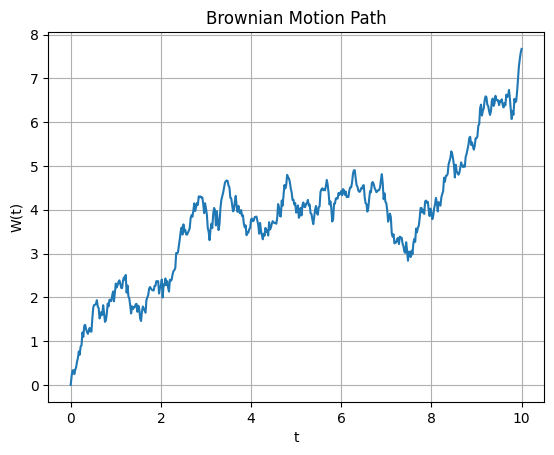

In [6]:
# Problem 1(a)

T = 10
N = 500
a = 1
sigma = 1
x0 = 5
M = 1000

t, W = simulate_brownian(T, N)

plt.plot(t, W)
plt.title("Brownian Motion Path")
plt.xlabel("t")
plt.ylabel("W(t)")
plt.grid(True)
plt.show()

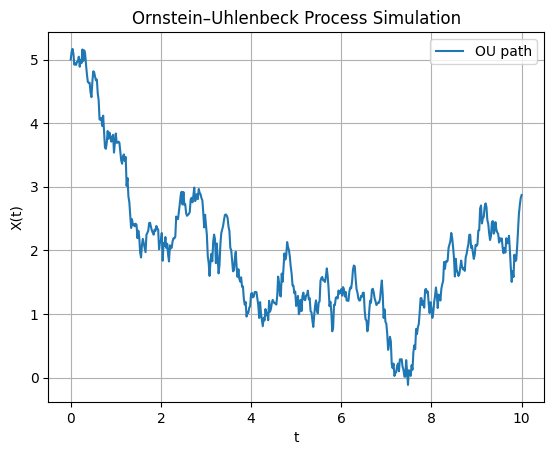

In [7]:
# Problem 1(b)

X_ou = simulate_OU_euler(a, sigma, x0, T, N, W)

plt.plot(t, X_ou, label="OU path")
plt.title("Ornstein–Uhlenbeck Process Simulation")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.grid(True)
plt.legend()
plt.show()

# Problem 1 (c)

### How to improve the numerical scheme?

To increase accuracy:

- **Decrease the timestep** \(dt = T/N\), i.e., use larger \(N\).  
- Use a **higher-order method** (e.g., Milstein scheme).  
- OR for OU specifically, we can use the **closed-form exact solution**, which eliminates discretization error entirely.

In [8]:
# Problem 1(d)

samples = monte_carlo_OU(a, sigma, x0, T, N, M)
mc_mean = samples.mean()
mc_var  = samples.var(ddof=1)

theo_mean = a
theo_var  = sigma**2 / 2

print("Monte Carlo Mean:", mc_mean)
print("Theoretical Mean:", theo_mean)
print("Monte Carlo Variance:", mc_var)
print("Theoretical Variance:", theo_var)

Monte Carlo Mean: 1.000567432670552
Theoretical Mean: 1
Monte Carlo Variance: 0.5361128909320372
Theoretical Variance: 0.5


# Problem 2 — Simulation of the CIR Model

CIR SDE:

\[
dX_t = (a - X_t)\, dt + \sigma \sqrt{X_t}\, dW_t, \qquad X_0 = x_0.
\]

We:

1. Simulate OU and CIR paths using the **same Brownian motion**.  
2. Compare trajectories.  
3. Perform Monte Carlo estimation.  
4. Explain why Euler scheme may break for CIR with large parameters.

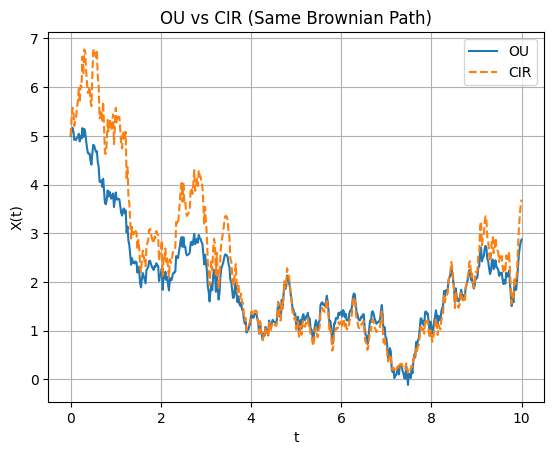

In [11]:
# Problem 2(a)

a_CIR = a_OU = 1
sigma_CIR = sigma_OU = 1
x0_CIR = x0_OU = 5

X_ou = simulate_OU_euler(a_OU, sigma_OU, x0_OU, T, N, W)
X_cir = simulate_CIR_euler(a_CIR, sigma_CIR, x0_CIR, T, N, W)

plt.plot(t, X_ou, label="OU")
plt.plot(t, X_cir, '--', label="CIR")
plt.title("OU vs CIR (Same Brownian Path)")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# Problem 2(b)

# Numerical parameters for this part:
a = 0.04
sigma = 0.01
x0 = 0.05
M = 1000

cir_samples = monte_carlo_CIR(a, sigma, x0, T, N, M)

print("CIR Monte Carlo Mean:", cir_samples.mean())
print("CIR Monte Carlo Variance:", cir_samples.var(ddof=1))

# Same OU parameters for comparison
ou_samples = monte_carlo_OU(a, sigma, x0, T, N, M)

print("OU Monte Carlo Mean:", ou_samples.mean())
print("OU Monte Carlo Variance:", ou_samples.var(ddof=1))

CIR Monte Carlo Mean: 0.04001729376986804
CIR Monte Carlo Variance: 2.040900865068036e-06
OU Monte Carlo Mean: 0.039926396665811645
OU Monte Carlo Variance: 4.772445115124469e-05


# Problem 2(c)

### Why does Euler fail for CIR with large parameters?

Euler updates:

\[
X_{n+1} = X_n + (a - X_n)\, dt + \sigma \sqrt{X_n}\, dW_n.
\]

When \(dW_n\) is negative and large, the term  
\(\sigma \sqrt{X_n}\, dW_n\)  
can pull the process **below zero**, even though the true CIR model is strictly non-negative.

If \(X_n < 0\), the square root becomes undefined → numerical breakdown.

CIR requires **positivity-preserving schemes** such as:

- Full-truncation Euler  
- Milstein with reflection  
- Exact sampling of CIR (noncentral chi-square distribution)

# Problem 3 — Feynman–Kac PDE Simulation

PDE:

\[
f_t + (1 - x) f_x + \frac{1}{2} f_{xx} = 0,\qquad
f(\ln 2, x) = e^x.
\]

Feynman–Kac tells us:

Let \(X_s\) solve

\[
dX_s = (1 - X_s)\, ds + dW_s.
\]

Then

\[
f(t, x) = \mathbb{E}\big[ e^{X_{\ln 2}} \mid X_t = x \big].
\]

In particular:

\[
f(0, x) = \mathbb{E}\big[ e^{X_{\ln 2}} \mid X_0 = x \big].
\]

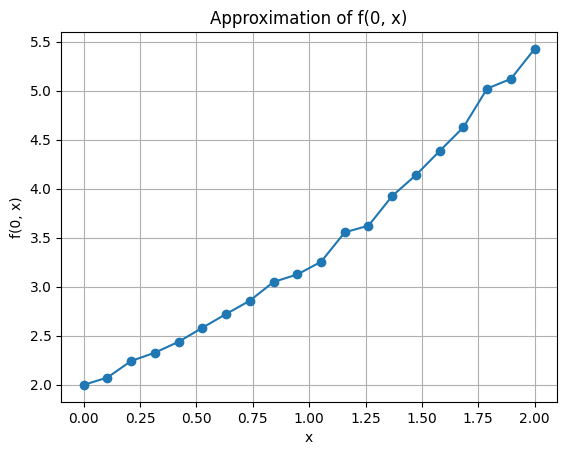

x=0.00, f(0,x)≈1.99753
x=0.11, f(0,x)≈2.07321
x=0.21, f(0,x)≈2.24190
x=0.32, f(0,x)≈2.32688
x=0.42, f(0,x)≈2.43807
x=0.53, f(0,x)≈2.58080
x=0.63, f(0,x)≈2.72116
x=0.74, f(0,x)≈2.85734
x=0.84, f(0,x)≈3.04851
x=0.95, f(0,x)≈3.12525
x=1.05, f(0,x)≈3.25375
x=1.16, f(0,x)≈3.55511
x=1.26, f(0,x)≈3.62304
x=1.37, f(0,x)≈3.92596
x=1.47, f(0,x)≈4.13984
x=1.58, f(0,x)≈4.38560
x=1.68, f(0,x)≈4.62721
x=1.79, f(0,x)≈5.02181
x=1.89, f(0,x)≈5.12134
x=2.00, f(0,x)≈5.42697


In [13]:
# Problem 3(b)

T_final = np.log(2)
N = 1000
M = 5000

xs = np.linspace(0, 2, 20)
f0_vals = estimate_f_at_time(0, xs, T_final, N, M)

plt.plot(xs, f0_vals, marker='o')
plt.title("Approximation of f(0, x)")
plt.xlabel("x")
plt.ylabel("f(0, x)")
plt.grid(True)
plt.show()

for xi, fi in zip(xs, f0_vals):
    print(f"x={xi:.2f}, f(0,x)≈{fi:.5f}")

# Problem 3(c)

### How to estimate f(0.1, x)?

Simply repeat the same Monte Carlo simulation, but starting at time \(t = 0.1\):

1. Compute  
   \[
   H = \ln(2) - 0.1.
   \]
2. Simulate the SDE for duration \(H\) starting at \(X_0 = x\).
3. Approximate  
   \[
   f(0.1, x) \approx \mathbb{E}\left[ e^{X_H} \right].
   \]

This is identical to part (b), just with a shorter horizon.

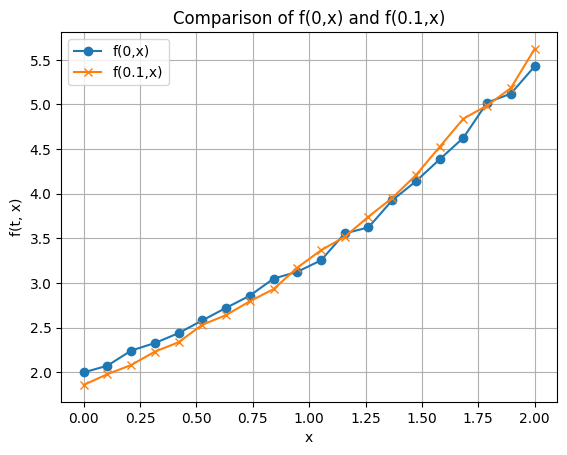

x=0.00, f(0.1,x)≈1.85742
x=0.11, f(0.1,x)≈1.97796
x=0.21, f(0.1,x)≈2.08044
x=0.32, f(0.1,x)≈2.23024
x=0.42, f(0.1,x)≈2.33600
x=0.53, f(0.1,x)≈2.53230
x=0.63, f(0.1,x)≈2.63971
x=0.74, f(0.1,x)≈2.79499
x=0.84, f(0.1,x)≈2.93093
x=0.95, f(0.1,x)≈3.17127
x=1.05, f(0.1,x)≈3.36631
x=1.16, f(0.1,x)≈3.51732
x=1.26, f(0.1,x)≈3.74285
x=1.37, f(0.1,x)≈3.95212
x=1.47, f(0.1,x)≈4.20836
x=1.58, f(0.1,x)≈4.52531
x=1.68, f(0.1,x)≈4.84137
x=1.79, f(0.1,x)≈4.98805
x=1.89, f(0.1,x)≈5.18401
x=2.00, f(0.1,x)≈5.62270


In [15]:
# Demo - Computing f(0.1, x)

f01_vals = estimate_f_at_time(0.1, xs, T_final, N, M)

plt.plot(xs, f0_vals, marker='o', label="f(0,x)")
plt.plot(xs, f01_vals, marker='x', label="f(0.1,x)")
plt.title("Comparison of f(0,x) and f(0.1,x)")
plt.xlabel("x")
plt.ylabel("f(t, x)")
plt.grid(True)
plt.legend()
plt.show()

for xi, fi in zip(xs, f01_vals):
    print(f"x={xi:.2f}, f(0.1,x)≈{fi:.5f}")